In [718]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns
import random
import plotly.graph_objects as go
import scipy.stats as stats

In [719]:
# load data
ego_updates = pd.read_csv('../Clean/ego_updates.csv')
stereo_updates = pd.read_csv('../Clean/stereo_updates.csv')
updates = pd.read_csv('../Clean/updates.csv')


# Preliminary Analysis

compute the distance to each of the simulated paths that corespond to the pair of theta and omega for each subject. Plot the simulation at 0 and the average deviation from the simulation for across all types.

take the simulation with the minimal distance for each data path and assign the subject to that model

Coumpute the share of paths that are assigned to each model.

Check if the assignment is different in the two treatments

Check if the distances are different in the two treatments

### The Shares of Subjects that are Overconfident, Underconfident and Correctly Specified

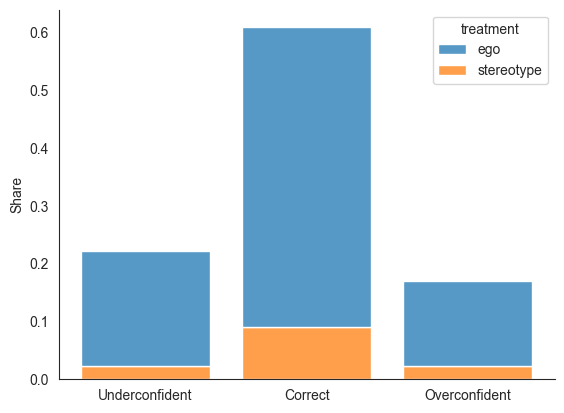

In [720]:
# from the table updates plot the shares of subjects in each of the misspecification categories
sns.set_style("white")

ax = sns.histplot(x="misspecification_num", hue="treatment", data=updates, 
                  multiple='stack', stat='probability', shrink=.8, discrete=True)
sns.despine()
plt.xlabel('')
plt.xticks([-1,0,1], ['Underconfident', 'Correct', 'Overconfident'])
plt.ylabel('Share')

#save figure
plt.savefig('../figures/misspecification_hist.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Misspecifications')

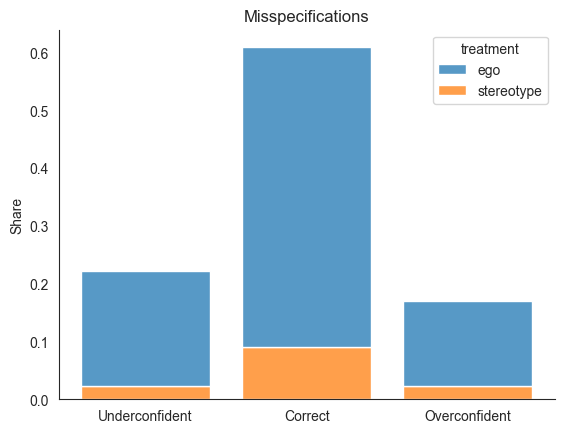

In [721]:
# from the table updates plot the shares of subjects in each of the misspecification categories
sns.set_style("white")

ax = sns.histplot(x="misspecification_num", hue="treatment", data=updates, 
                  multiple='stack', stat='probability', shrink=.8, discrete=True)
sns.despine()
plt.xlabel('')
plt.xticks([-1,0,1], ['Underconfident', 'Correct', 'Overconfident'])
plt.ylabel('Share')
plt.title('Misspecifications')

Text(0.5, 1.0, 'round 10')

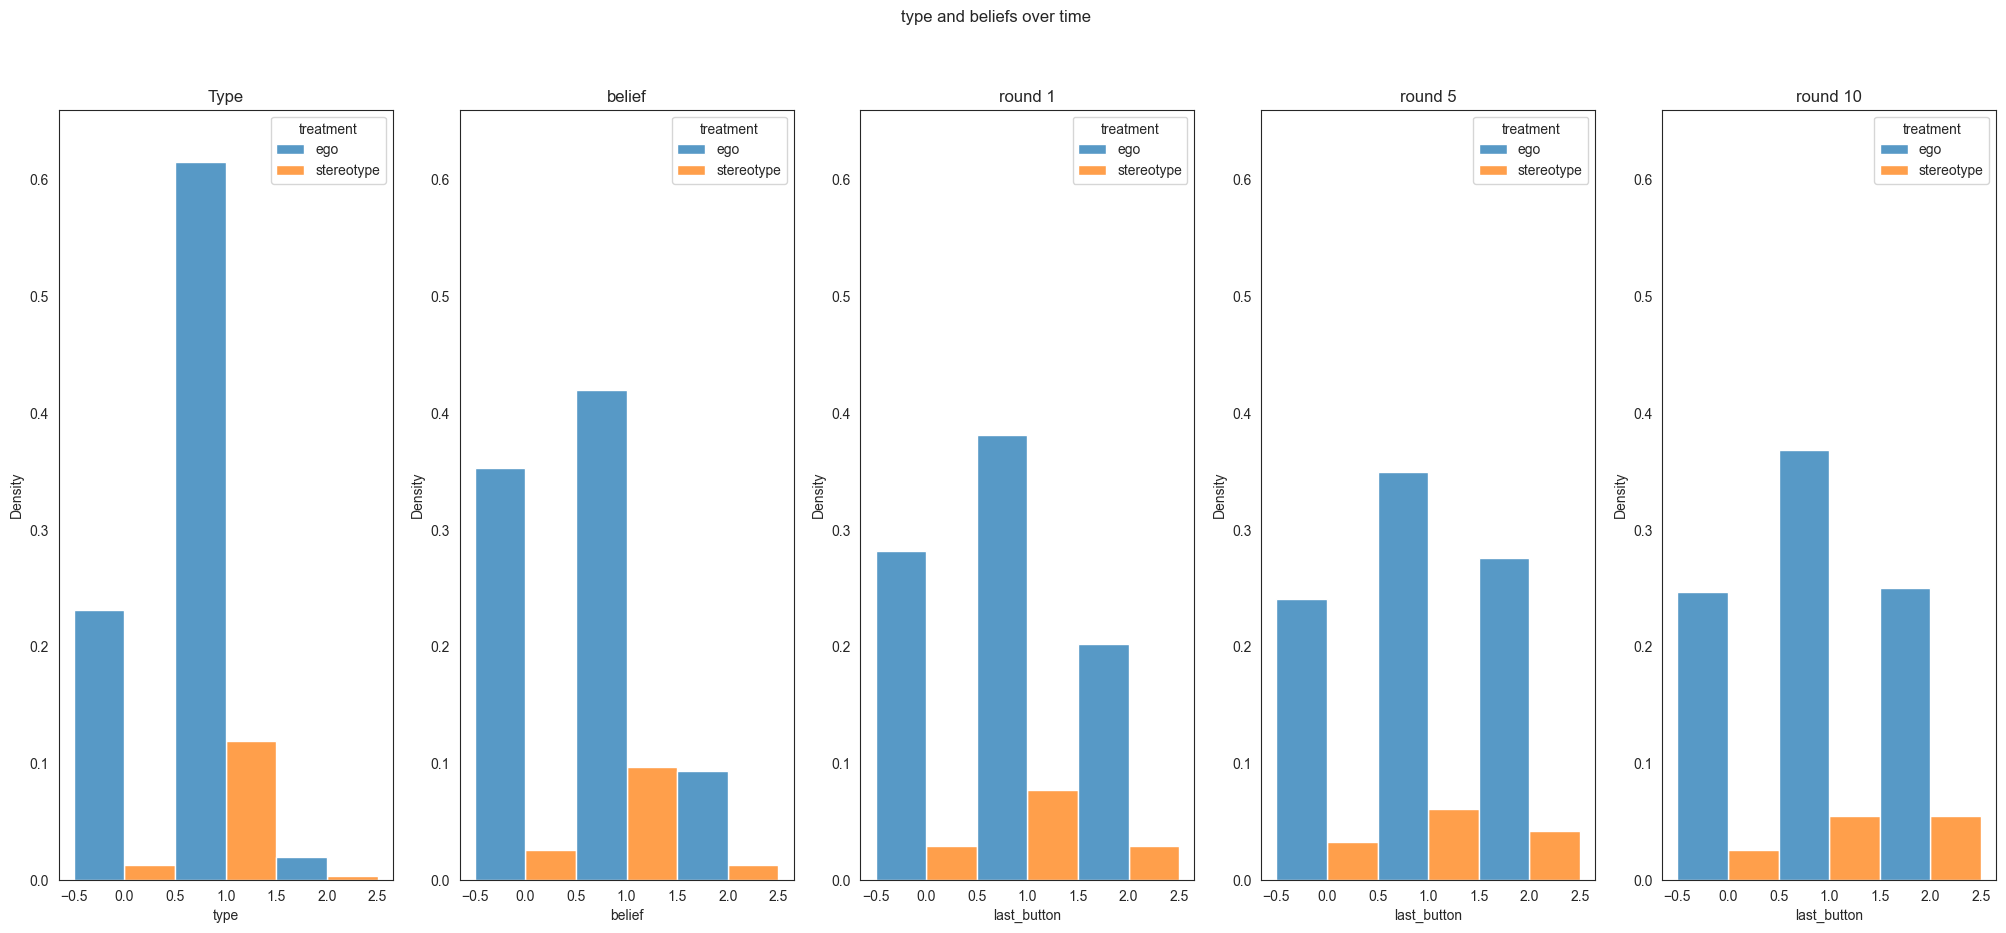

In [722]:
fig, axs = plt.subplots(1, 5, figsize=(25, 10))

fig.suptitle('type and beliefs over time')

sns.histplot(data=updates, x='type', ax=axs[0], discrete=True, hue='treatment', multiple='dodge', stat='density')
sns.histplot(data=updates, x='belief', ax=axs[1], discrete=True, hue='treatment', multiple='dodge', stat='density')
sns.histplot(data=updates[updates['round_number']==1], x='last_button', ax=axs[2], discrete=True, hue='treatment', multiple='dodge', stat='density')
sns.histplot(data=updates[updates['round_number']==5], x='last_button', ax=axs[3], discrete=True, hue='treatment', multiple='dodge', stat='density')
sns.histplot(data=updates[updates['round_number']==11], x='last_button', ax=axs[4], discrete=True, hue='treatment', multiple='dodge', stat='density')

axs[0].set_ylim((0, .66))
axs[1].set_ylim((0, .66))
axs[2].set_ylim((0, .66))
axs[3].set_ylim((0, .66))
axs[4].set_ylim((0, .66))

axs[0].set_title('Type')
axs[1].set_title('belief')
axs[2].set_title('round 1')
axs[3].set_title('round 5')
axs[4].set_title('round 10')


## Add a column that indicates if their type-belief changed from the previous round

In [723]:
# assign a number code to each of the topics to create an id column that has the participant code and the topic they were updating on.
updates.loc[updates['topic']=='Math', 'topic_num'] = '1'
updates.loc[updates['topic']=='Science and Technology', 'topic_num'] = '2'
updates.loc[updates['topic']=='Verbal', 'topic_num'] = '3'
updates.loc[updates['topic']=='Pop-Culture and Art', 'topic_num'] = '4'
updates.loc[updates['topic']=='Sports and Video Games', 'topic_num'] = '5'
updates.loc[updates['topic']=='US Geography', 'topic_num'] = '6'

# make a column that combines the participant code and the topic number into a singe id for a participant in a task.
updates['player_code'] = updates['code']+updates['topic_num']

updates.reset_index(inplace=True)

 
# need to rename the columns type and rate from updates to theta and omega
updates = updates.rename(columns={'type':'theta', 'rate':'omega'})




In [724]:
### Add columns to determine how the Subject's beliefs about their type changed across rounds
# for each task, determine whether their belief changed from the initial belief or not.
# check at every row if the belief is different from the last_button. 
updates['current_belief_start'] = updates['last_button'] - updates['belief']

# for rows in which rond_number is 2 or more, check if last_button is the same as last_button in the previous round_number for that player_code
# and register the size of the belief change in the column belief_change
updates['belief_change'] = np.where(updates['round_number']>1, 
                                     updates['last_button'] - updates['last_button'].shift(1), 
                                     updates['current_belief_start'])

# create a column that indicates if the belief changed or not in that round relative to the previous round
updates['change_indicator'] = 0
updates.loc[updates['belief_change']!=0, 'change_indicator'] = 1
# split the sample into two. Those who never changed their belief and those who did
# to do so, first group by player_code and then check if the sum of the change_indicator is 0 or not
updates['change_indicator_sum'] = updates.groupby('player_code')['change_indicator'].transform('sum')





In [725]:
epsilon = updates['change_indicator_sum'].mean()

In [726]:
epsilon

3.5576923076923075

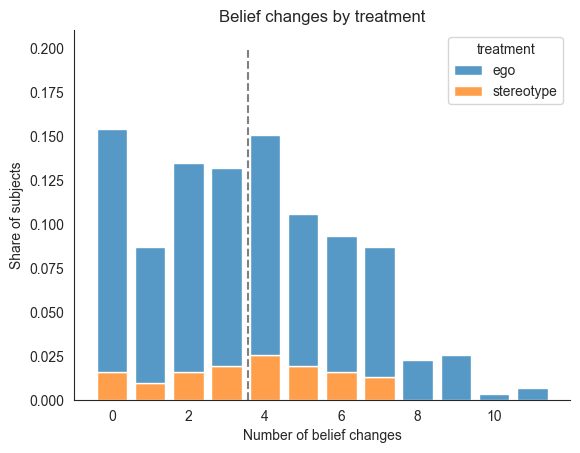

In [727]:
# if the indicator is more than 0 then the belief changed at least once and these subjects cannot possibly be dogmatic.
# plot the share of subjects for whom the belief never changed and the share for whom it did
sns.set_style("white")
sns.histplot(data=updates, x='change_indicator_sum', hue='treatment', multiple='stack', stat='probability', shrink=.8, discrete=True)
sns.despine()
plt.xlabel('Number of belief changes')
plt.ylabel('Share of subjects')
plt.title('Belief changes by treatment')

plt.vlines(x=epsilon, ymin=0, ymax=.2, linestyles='--', colors='gray')

In [728]:
updates.columns

Index(['index', 'code', 'round_number', 'effort', 'fails', 'last_button',
       'score', 'topic', 'signal', 'belief', 'certainty', 'theta', 'omega',
       'treatment', 'overconfident', 'underconfident', 'correct',
       'misspecification', 'gender', 'nationality', 'misspecification_num',
       'topic_num', 'player_code', 'current_belief_start', 'belief_change',
       'change_indicator', 'change_indicator_sum'],
      dtype='object')

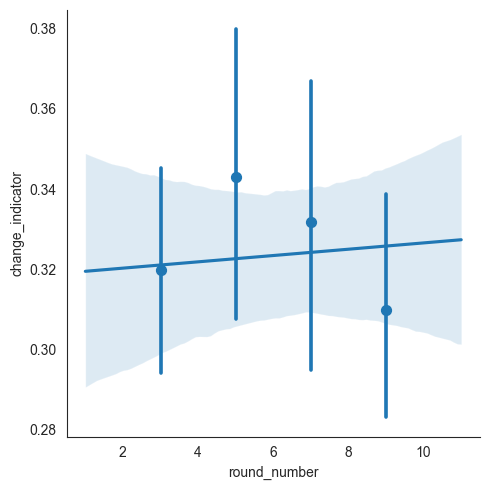

In [729]:
# make a point plot of the the share of subjects for whom change_indicator is 1 across rounds in 4 groups of rounds
# 1-5, 6-10, 11-15, 16-20
sns.set_style("white")
sns.lmplot(data=updates, x='round_number', y='change_indicator', x_bins=4)



## Likelihoods

In [730]:
## Likelihoods
#for each subject, calulate the likelihood of each of the types given the signals they saw.
# the probability matrices are needed for th calculatin of the likelihood
ml = np.array([[.20, .25, .40], [.07, .30, .45], [.02, .20, .50]])
mm = np.array([[.40, .45, .65], [.30, .65, .69], [.05, .50, .80]])
mh = np.array([[.45, .55, .75], [.35, .69, .80], [.25, .65, .98]])

msc = [ml, mm, mh]

for i in range(len(updates['player_code'].unique())):
    # get a single path for a single player
    c = updates['player_code'].unique()[i]
    player = updates.loc[updates['player_code']==c, :]
    # for each round get the history of (effort, signal) pairs up to that round
    p_t=[]
    lr_t=[]
    prior = [1/3, 1/3, 1/3]

    for t in range(11):
        
        e_t = int(player.loc[player['round_number']==t+1, 'effort'])
        theta = int(player.loc[player['round_number']==t+1, 'theta'])
        belief = int(player.loc[player['round_number']==t+1, 'belief'])
        omega = int(player.loc[player['round_number']==t+1, 'omega'])
        s_t = int(player.loc[player['round_number']==t+1, 'signal'])
        f_t = 10-s_t

        # update the belief about omega for each of the types separately
        posterior_true = np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[theta][e_t, :], loc=0)))/sum(np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[theta][e_t, :], loc=0))))
        posterior_belief = np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief][e_t, :], loc=0)))/sum(np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief][e_t, :], loc=0))))

        p_true = sp.stats.binom.pmf(s_t, 10, msc[theta][e_t, :], loc=0)@posterior_true
        p_belief = sp.stats.binom.pmf(s_t, 10, msc[belief][e_t, :], loc=0)@posterior_belief
        # multiply all the elements in p_true and p_belief
        l_true = np.prod(p_true)
        l_belief = np.prod(p_belief)
        # calculate the likelihood ratio
        lr_t.append(l_true/l_belief)
    # add a column to the updates data frame with the likelihood ratio for each round
    updates.loc[updates['player_code']==c, 'lr'] = lr_t

## Compute alpha


In [731]:
# calculate the average of lr for the rows in which change_indicator is 1
alpha = updates.loc[(updates['change_indicator']==1) & (updates['lr']<5), 'lr'].mean()
alpha

1.1185418757160377

In [732]:
alpha_ego = updates.loc[(updates['change_indicator']==1) & (updates['lr']<5) & (updates['treatment']=='ego'), 'lr'].mean()
alpha_stereo = updates.loc[(updates['change_indicator']==1) & (updates['lr']<5) & (updates['treatment']=='stereotype'), 'lr'].mean()

print('alpha is ' + str(alpha_ego) + 'in the ego condition')
print('alpha is ' + str(alpha_stereo) + 'in the stereotype condition')

alpha is 1.1224128683482018in the ego condition
alpha is 1.0942944079784547in the stereotype condition


#### Test if the alphas are different in the two treatments

In [733]:
stats.ttest_ind(updates.loc[(updates['treatment']=='ego') & 
                            (updates['change_indicator']==1) & 
                            (updates['lr']<5) , 'lr'], 
                updates.loc[(updates['treatment']=='stereotype') & 
                            (updates['change_indicator']==1) & 
                            (updates['lr']<5), 'lr'])

Ttest_indResult(statistic=0.5664560607732722, pvalue=0.5712055422670466)

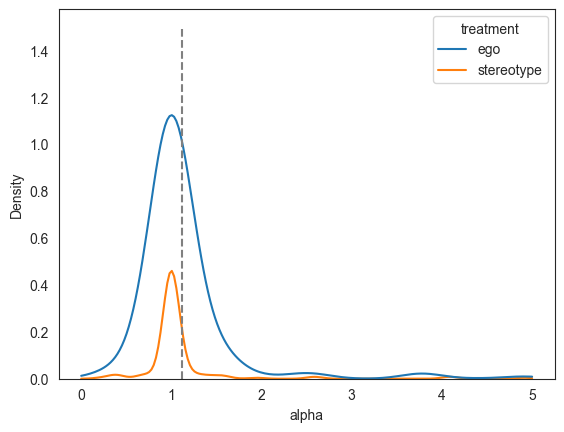

In [734]:
# estimate the distribution of alpha
# take the log of the lr
updates['log_lr'] = np.log(updates['lr'])
# plot the distribution of log_lr
sns.kdeplot(data = updates.loc[(updates['change_indicator']==1)], x = 'lr', 
            hue='treatment', clip=(0, 5), bw_adjust=.1)
plt.xlabel('alpha')
plt.vlines([alpha], 0, 1.5, color = 'gray', linestyles='--')

In [735]:
len(updates.loc[(updates['change_indicator']==1) & (updates['lr']<0.9)])/len(updates.loc[(updates['change_indicator']==1)])

0.10270270270270271

In [736]:
alpha_subjects = updates[updates['change_indicator']==1].groupby(['code'])['lr', 'theta', 'belief', 'last_button'].mean()
alpha_subjects.reset_index(inplace=True)

/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_30290/2835870841.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  alpha_subjects = updates[updates['change_indicator']==1].groupby(['code'])['lr', 'theta', 'belief', 'last_button'].mean()


In [737]:
len(updates['code'].unique())

52

Text(0.5, 1.0, 'Switching Threshold by treatment')

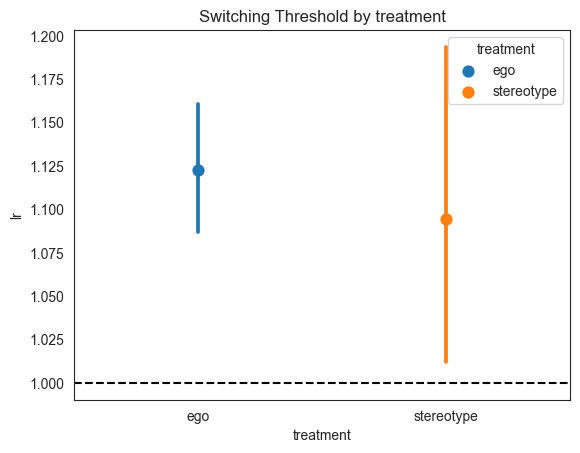

In [738]:
# plot the estimates of alpha by treatment
sns.pointplot(data=updates[(updates['change_indicator']==1) & (updates['lr']<5)], y='lr', x='treatment', join =False, hue='treatment')
plt.axhline(y=1, color='black', linestyle='--')
plt.title('Switching Threshold by treatment')

Text(0.5, 1.0, 'Average number of belief changes by misspecification')

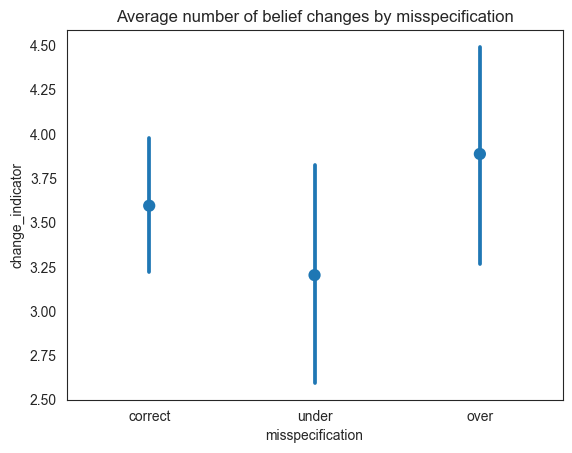

In [739]:
# count the number of belief changes for each subject
total_changes = updates.groupby(['player_code', 'misspecification', 'treatment'])['change_indicator'].sum()

# plot the average number of belief changes by misspecifiaction
sns.pointplot(data=total_changes.reset_index(), y='change_indicator', x='misspecification', join =False)
plt.title('Average number of belief changes by misspecification')

Text(0.5, 1.0, 'Switching Threshold by misspecifiaction')

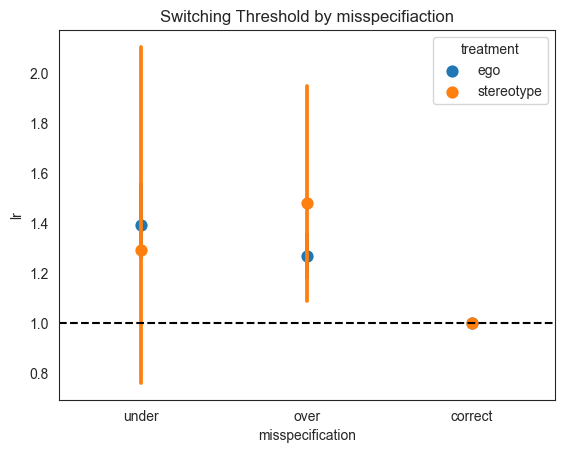

In [740]:
# plot the estimates of alpha by treatment
sns.pointplot(data=updates[(updates['change_indicator']==1) & (updates['lr']<5)], 
              y='lr', x='misspecification', join =False, hue='treatment')
plt.axhline(y=1, color='black', linestyle='--')
plt.title('Switching Threshold by misspecifiaction')

/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_30290/2915667402.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = updates.loc[(updates['change_indicator']==1)], x = 'lr', hue='misspecification', clip=(0, 5), bw_adjust=.1)


<Axes: xlabel='lr', ylabel='Density'>

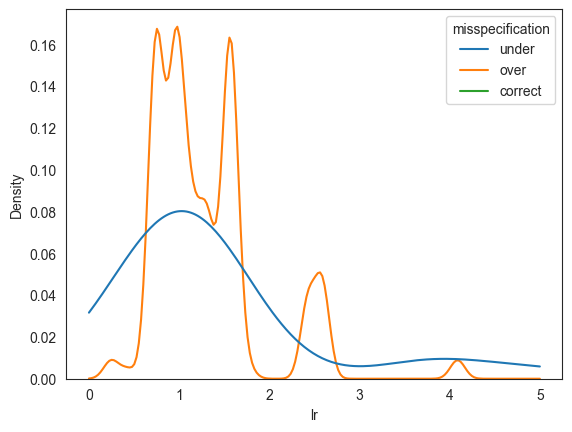

In [741]:
# plot the distribution of lr for the cases in which the belief changes and the subjec's misspecification is correct
sns.kdeplot(data = updates.loc[(updates['change_indicator']==1)], x = 'lr', hue='misspecification', clip=(0, 5), bw_adjust=.1)

** Should it be gender/topic specific? test if they are different*
This requires adding the gender data to the updates table

In [742]:
# use alpha to simulate the switcher's path. 

## Add the simulation data and reshape to merge to the experiment's data

In [743]:
# import the simulation data
sim = pd.read_csv("../Simulations/demo/data/simulation.csv")

In [744]:
updates['topic'].unique()

array(['Science and Technology', 'Math', 'Verbal', 'Pop-Culture and Art',
       'Sports and Video Games', 'US Geography'], dtype=object)

In [745]:
# split the data by initial belief and add the relevant simulations given the initial belief and the true omega and theta
initial_L = updates.loc[updates['belief']==0]
initial_M = updates.loc[updates['belief']==1]
initial_H = updates.loc[updates['belief']==2]




In [746]:
# adjust the round numbers from the simulation to match the data (get rif od rounf 0 of the simulation, it was just the starting parameters)
sim['round_number_modif'] = sim['round_number']+1
sim['round_number_modif'] = sim['round_number_modif'].astype(int)

# split the simulations by initial beliefs
sim_L = sim[['e_lr_L', 'e_dog_L', 'e_bay', 'e_ss', 'e_joint', 'theta_lr_L', 'theta', 'omega', 'round_number_modif']]
sim_M = sim[['e_lr_M', 'e_dog_M', 'e_bay', 'e_ss', 'e_joint', 'theta_lr_M', 'theta', 'omega', 'round_number_modif']]
sim_H = sim[['e_lr_H', 'e_dog_H', 'e_bay', 'e_ss', 'e_joint', 'theta_lr_H', 'theta', 'omega', 'round_number_modif']]



In [747]:
sim_L = sim_L.rename(columns={'e_lr_L':'switcher', 
                      'e_dog_L':'dogmatic', 
                      'e_ss':'self-serving', 
                      'e_bay':'bayesian',
                      'e_joint':'joint-bayesian', 
                      'theta_lr_L':'switcher_belief',
                      'round_number_modif':'round_number'})

sim_M = sim_M.rename(columns={'e_lr_M':'switcher', 
                      'e_dog_M':'dogmatic', 
                      'e_ss':'self-serving', 
                      'e_bay':'bayesian', 
                      'e_joint':'joint-bayesian',
                      'theta_lr_M':'switcher_belief',
                      'round_number_modif':'round_number'})

sim_H = sim_H.rename(columns={'e_lr_H':'switcher', 
                      'e_dog_H':'dogmatic', 
                      'e_ss':'self-serving', 
                      'e_bay':'bayesian', 
                      'e_joint':'joint-bayesian',
                      'theta_lr_H':'switcher_belief',
                      'round_number_modif':'round_number'})

In [748]:
sim_L['belief'] = 0
sim_M['belief'] = 1
sim_H['belief'] = 2

In [749]:
sim = pd.concat([sim_L, sim_M, sim_H])

In [750]:
# merge with the update data on the round number, the belief and the theta and omega. 
updates = updates.merge(sim, on=['round_number', 'belief', 'theta', 'omega'], how='left')

## Distances to the simulated paths

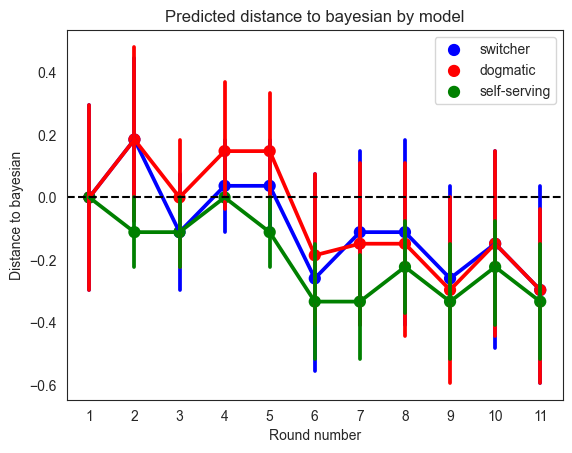

In [751]:
# compare the simulations to the bayesian simulation by taking the distance from each of the simulations to the bayesian simulation
# and then plot all of them
# first take the distance from switcher to bayesian
sim['switcher_bayesian'] = sim['switcher'] - sim['bayesian']
# then take the distance from dogmatic to bayesian
sim['dogmatic_bayesian'] = sim['dogmatic'] - sim['bayesian']
# then take the distance from self-serving to bayesian
sim['self-serving_bayesian'] = sim['self-serving'] - sim['bayesian']

# plot each of the distances as a line in the same plot
sns.set_style("white")
sns.pointplot(data=sim, x='round_number', y='switcher_bayesian', label='switcher', color='blue')
sns.pointplot(data=sim, x='round_number', y='dogmatic_bayesian', label='dogmatic', color='red')
sns.pointplot(data=sim, x='round_number', y='self-serving_bayesian', label='self-serving', color='green')
# add a horizontal line at 0
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('Distance to bayesian')
plt.xlabel('Round number')
plt.title('Predicted distance to bayesian by model')
plt.legend()

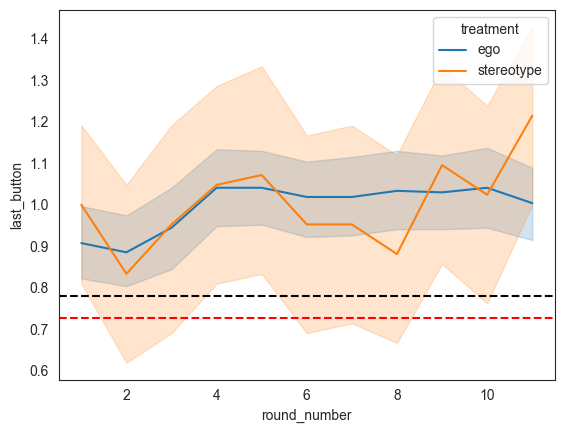

In [752]:
# tracking the last button
sns.lineplot(data=updates, x='round_number', y='last_button', hue='treatment')
avg_type = np.mean(updates['theta'])
avg_belief = np.mean(updates['belief'])
plt.axhline(y=avg_type, color='black', linestyle='--', label='average theta')
plt.axhline(y=avg_belief, color='red', linestyle='--', label='average belief') 


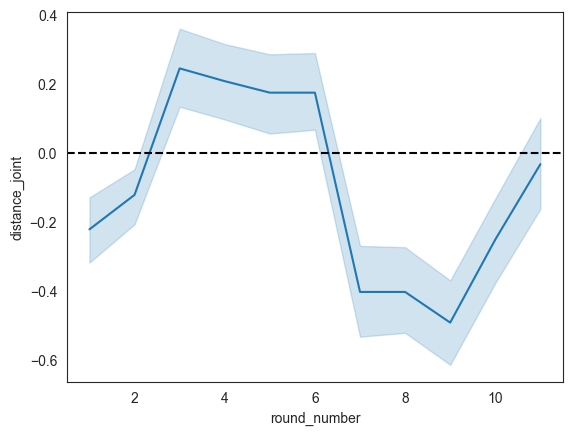

In [753]:
# compute the distance between the observed effort choices and what a bayesian agent would have done
updates['distance_joint'] = updates['effort']- updates['joint-bayesian']

# plot the distance over rounds for each of the treatments
sns.set_style("white")
sns.lineplot(data=updates[updates['treatment']=='ego'], x='round_number', y='distance_joint')
#sns.lineplot(data=sim, x='round_number', y='switcher_bayesian', label='switcher', color='blue')
#sns.lineplot(data=sim, x='round_number', y='dogmatic_bayesian', label='dogmatic', color='red')
#sns.lineplot(data=sim, x='round_number', y='self-serving_bayesian', label='self-serving', color='green')
# add a horizontal line at 0 to indicate the bayesian choice
plt.axhline(y=0, color='black', linestyle='--') 

plt.savefig('../figures/distance_joint.png', dpi=300)

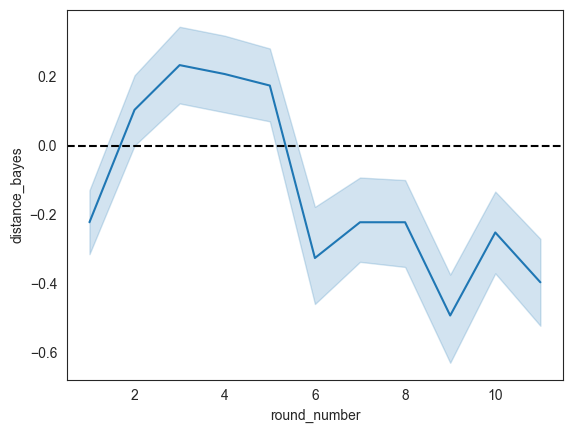

In [754]:
# compute the distance between the observed effort choices and what a bayesian agent would have done
updates['distance_bayes'] = updates['effort']- updates['bayesian']

# plot the distance over rounds for each of the treatments
sns.set_style("white")
sns.lineplot(data=updates[updates['treatment']=='ego'], x='round_number', y='distance_bayes')
#sns.lineplot(data=sim, x='round_number', y='switcher_bayesian', label='switcher', color='blue')
#sns.lineplot(data=sim, x='round_number', y='dogmatic_bayesian', label='dogmatic', color='red')
#sns.lineplot(data=sim, x='round_number', y='self-serving_bayesian', label='self-serving', color='green')
# add a horizontal line at 0 to indicate the bayesian choice
plt.axhline(y=0, color='black', linestyle='--') 

plt.savefig('../figures/distance_bayes.png', dpi=300)


## Do the plots for each case of misspecification separately. 


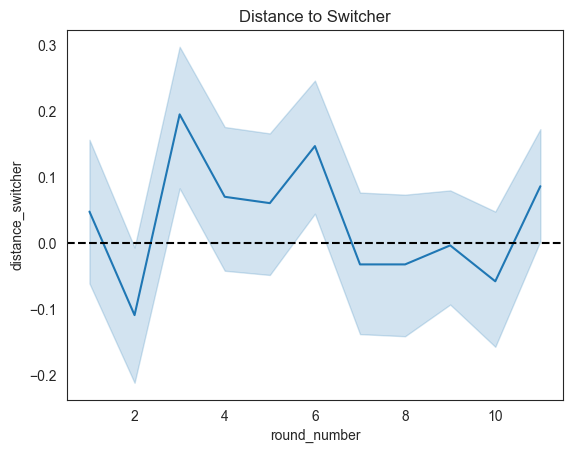

In [755]:
# compute the difference between effort and each of the simulated models
updates['distance_switcher'] = updates['effort'] - updates['switcher']
updates['distance_dogmatic'] = updates['effort'] - updates['dogmatic']
updates['distance_bayesian'] = updates['effort'] - updates['bayesian']
updates['distance_self-serving'] = updates['effort'] - updates['self-serving']

# plot the distance over rounds for each of the MODES

# plot the distance over rounds for each of the treatments and each of the models
# first plot the distance to the switcher
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_switcher')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Switcher')
plt.savefig('../figures/distance_switcher.png')

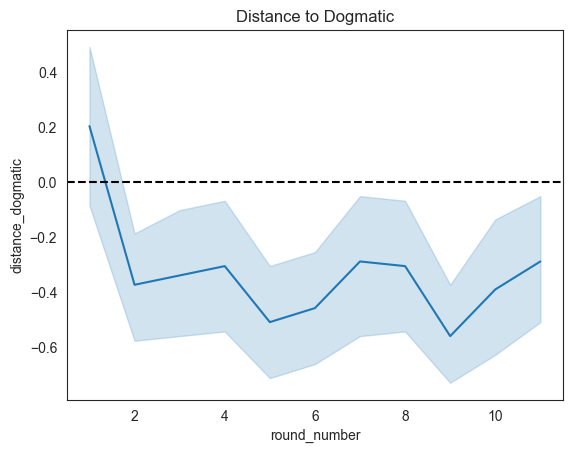

In [756]:
# the dogmatic model only applies to a subset of cases. I take only those in a different data frame called dogmatic_updates
dogmatic_updates = updates[(updates['theta']==0) & (updates['omega']==2) & (updates['belief']==1)|
                           (updates['theta']==1) & (updates['omega']==0) & (updates['belief']==0)|
                           (updates['theta']==1) & (updates['omega']==1) & (updates['belief']==0)|
                           (updates['theta']==1) & (updates['omega']==1) & (updates['belief']==2)|
                           (updates['theta']==1) & (updates['omega']==2) & (updates['belief']==2)|
                           (updates['theta']==2) & (updates['omega']==1) & (updates['belief']==1)]

# plot the distance to the dogmatic
sns.set_style("white")
sns.lineplot(data=dogmatic_updates, x='round_number', y='distance_dogmatic')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Dogmatic')

plt.savefig('../figures/distance_dogmatic.png')

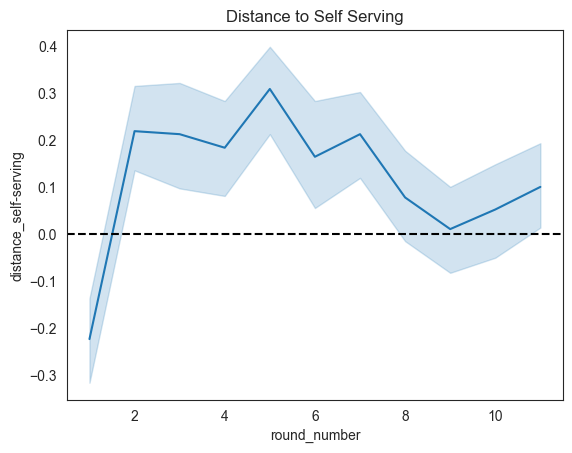

In [757]:
# plot the distance to the self-serving
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_self-serving')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Self Serving')

plt.savefig('../figures/distance_self-serving.png')

In [758]:
# create a function that takes in theta and omega and the data and returns 8 plots
def plot(data, theta, omega):
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 15))

    table = data.loc[(data['theta']==theta) & (data['omega']==omega), :]

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[0,0])
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='switcher', ax=axs[0,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[0,1])
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='switcher', ax=axs[0,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[0,2])
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='switcher', ax=axs[0,2], color='black')

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[1,0])
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='dogmatic', ax=axs[1,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[1,1])
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='dogmatic', ax=axs[1,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[1,2])
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='dogmatic', ax=axs[1,2], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,0])
    sns.lineplot(data=table, x='round_number', y='bayesian', ax=axs[2,0], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,1])
    sns.lineplot(data=table, x='round_number', y='self-serving', ax=axs[2,1], color='black')
    
    
    axs[0, 0].set_title('switcher, belief L')
    axs[0, 1].set_title('switcher, belief M')
    axs[0, 2].set_title('switcher, belief H')

    
    axs[1, 0].set_title('dogmatic, belief L')
    axs[1, 1].set_title('dogmatic, belief M')
    axs[1, 2].set_title('dogmatic, belief H')

   
    axs[2, 0].set_title('Bayesian')
    axs[2, 1].set_title('Self Serving')
    
    axs[0, 0].set_ylim(-0.5, 2.5)
    axs[0, 1].set_ylim(-.5, 2.5)
    axs[0, 2].set_ylim(-.5, 2.5)
    axs[1, 0].set_ylim(-.5, 2.5)
    axs[1, 1].set_ylim(-.5, 2.5)
    axs[1, 2].set_ylim(-.5, 2.5)
    axs[2, 0].set_ylim(-.5, 2.5)
    axs[2, 1].set_ylim(-.5, 2.5)
    axs[2, 2].set_ylim(-.5, 2.5)

    if theta == 1:
        type = 'Mid Type'
    if theta ==0:
        type = 'Low Type'
    if theta ==2:
        type = 'High Type'

    axs[2,0].set_xlabel('round')
    axs[2,1].set_xlabel('round')
    axs[2,2].set_xlabel('round')

    axs[0, 0].set_ylabel('effort choice')
    axs[1, 0].set_ylabel('effort choice')
    axs[2, 0].set_ylabel('effort choice')

    axs[0, 0].set_yticks([0, 1, 2])
    axs[1, 0].set_yticks([0, 1, 2])
    axs[2, 0].set_yticks([0, 1, 2])

    axs[0, 1].set_yticks([0, 1, 2])
    axs[1, 1].set_yticks([0, 1, 2])
    axs[2, 1].set_yticks([0, 1, 2])

    axs[0, 2].set_yticks([0, 1, 2])
    axs[1, 2].set_yticks([0, 1, 2])
    axs[2, 2].set_yticks([0, 1, 2])
    
    fig.suptitle(type + ', rate = '+str(omega))

In [759]:
# make all the plots and save them in the figures folder
for t in [0,1,2]:
    for o in [0,1,2]:
        plot(updates, t, o)
        plt.savefig('../figures/updates_'+str(t)+str(o)+'.png')
        plt.close()

In [760]:
# create a function that takes in theta and omega and the data and returns 8 plots and plots each treatment separately
def plot_treatment(data, theta, omega):
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 15))

    table = data.loc[(data['theta']==theta) & (data['omega']==omega), :]

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[0,0], hue='treatment')
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='switcher', ax=axs[0,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[0,1], hue='treatment')
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='switcher', ax=axs[0,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[0,2], hue='treatment')
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='switcher', ax=axs[0,2], color='black')

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[1,0], hue='treatment')
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='dogmatic', ax=axs[1,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[1,1], hue='treatment')
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='dogmatic', ax=axs[1,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[1,2], hue='treatment')
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='dogmatic', ax=axs[1,2], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,0], hue='treatment')
    sns.lineplot(data=table, x='round_number', y='bayesian', ax=axs[2,0], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,1], hue='treatment')
    sns.lineplot(data=table, x='round_number', y='self-serving', ax=axs[2,1], color='black')
    
    
    axs[0, 0].set_title('switcher, belief L')
    axs[0, 1].set_title('switcher, belief M')
    axs[0, 2].set_title('switcher, belief H')

    
    axs[1, 0].set_title('dogmatic, belief L')
    axs[1, 1].set_title('dogmatic, belief M')
    axs[1, 2].set_title('dogmatic, belief H')

   
    axs[2, 0].set_title('Bayesian')
    axs[2, 1].set_title('Self Serving')
    
    axs[0, 0].set_ylim(-0.5, 2.5)
    axs[0, 1].set_ylim(-.5, 2.5)
    axs[0, 2].set_ylim(-.5, 2.5)
    axs[1, 0].set_ylim(-.5, 2.5)
    axs[1, 1].set_ylim(-.5, 2.5)
    axs[1, 2].set_ylim(-.5, 2.5)
    axs[2, 0].set_ylim(-.5, 2.5)
    axs[2, 1].set_ylim(-.5, 2.5)
    axs[2, 2].set_ylim(-.5, 2.5)

    if theta == 1:
        type = 'Mid Type'
    if theta ==0:
        type = 'Low Type'
    if theta ==2:
        type = 'High Type'

    axs[2,0].set_xlabel('round')
    axs[2,1].set_xlabel('round')
    axs[2,2].set_xlabel('round')

    axs[0, 0].set_ylabel('effort choice')
    axs[1, 0].set_ylabel('effort choice')
    axs[2, 0].set_ylabel('effort choice')

    axs[0, 0].set_yticks([0, 1, 2])
    axs[1, 0].set_yticks([0, 1, 2])
    axs[2, 0].set_yticks([0, 1, 2])

    axs[0, 1].set_yticks([0, 1, 2])
    axs[1, 1].set_yticks([0, 1, 2])
    axs[2, 1].set_yticks([0, 1, 2])

    axs[0, 2].set_yticks([0, 1, 2])
    axs[1, 2].set_yticks([0, 1, 2])
    axs[2, 2].set_yticks([0, 1, 2])
    
    fig.suptitle(type + ', rate = '+str(omega))

In [761]:
# make all the plots and save them in the figures folder
for t in [0,1,2]:
    for o in [0,1,2]:
        plot_treatment(updates, t, o)
        plt.savefig('../figures/updates_by_treatment'+str(t)+str(o)+'.png')
        plt.close()

# Try to Classify subjects based on their behavior

In [762]:
updates.columns

Index(['index', 'code', 'round_number', 'effort', 'fails', 'last_button',
       'score', 'topic', 'signal', 'belief', 'certainty', 'theta', 'omega',
       'treatment', 'overconfident', 'underconfident', 'correct',
       'misspecification', 'gender', 'nationality', 'misspecification_num',
       'topic_num', 'player_code', 'current_belief_start', 'belief_change',
       'change_indicator', 'change_indicator_sum', 'lr', 'log_lr', 'switcher',
       'dogmatic', 'bayesian', 'self-serving', 'joint-bayesian',
       'switcher_belief', 'distance_joint', 'distance_bayes',
       'distance_switcher', 'distance_dogmatic', 'distance_bayesian',
       'distance_self-serving'],
      dtype='object')

In [763]:
# compute the difference between effort and each of the simulated models
updates['distance_switcher_abs'] = np.abs(updates['effort'] - updates['switcher'])
updates['distance_dogmatic_abs'] = np.abs(updates['effort'] - updates['dogmatic'])
updates['distance_bayesian_abs'] = np.abs(updates['effort'] - updates['bayesian'])
updates['distance_self-serving_abs'] = np.abs(updates['effort'] - updates['self-serving'])

# create a new data set with the sum the computed distences by player_code for each of the models
distances = pd.DataFrame()
distances['distance_switcher_sum'] = updates.groupby('code')['distance_switcher_abs'].sum()
distances['distance_dogmatic_sum'] = updates.groupby('code')['distance_dogmatic_abs'].sum()
distances['distance_bayesian_sum'] = updates.groupby('code')['distance_bayesian_abs'].sum()
distances['distance_self-serving_sum'] = updates.groupby('code')['distance_self-serving_abs'].sum()

# for each player_code, return the model that has the smallest sum
distances['best_model'] = np.argmin(distances[['distance_switcher_sum', 'distance_dogmatic_sum', 'distance_bayesian_sum', 'distance_self-serving_sum']].values, axis=1)

# merge with the updates data 
updates = updates.merge(distances, on='code', how='left')

In [764]:
# make a data frame with the average distances by subject.
subject_models=updates.groupby(['code', 'treatment']).mean('best_model')
subject_models.reset_index(inplace=True)


In [765]:
# for each subject, take the average distance of the best fittig model and set it in a new column
subject_models.loc[subject_models['best_model']==0, 'min_distance'] = subject_models.loc[subject_models['best_model']==0, 'distance_switcher_sum']
subject_models.loc[subject_models['best_model']==1, 'min_distance'] = subject_models.loc[subject_models['best_model']==1, 'distance_dogmatic_sum']
subject_models.loc[subject_models['best_model']==2, 'min_distance'] = subject_models.loc[subject_models['best_model']==2, 'distance_bayesian_sum']
subject_models.loc[subject_models['best_model']==3, 'min_distance'] = subject_models.loc[subject_models['best_model']==3,'distance_self-serving_sum']


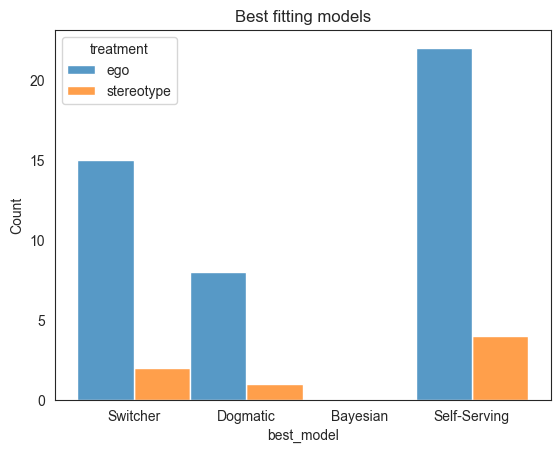

In [766]:
#count the number of subjects for which each of the models id the best fitting among all 4 of them
sns.histplot(data=subject_models, x='best_model', discrete=True, hue='treatment', multiple='dodge')
plt.xticks([0, 1, 2, 3], ['Switcher', 'Dogmatic', 'Bayesian', 'Self-Serving'])
plt.title('Best fitting models')
plt.savefig('../figures/model_fit_histogram.png')

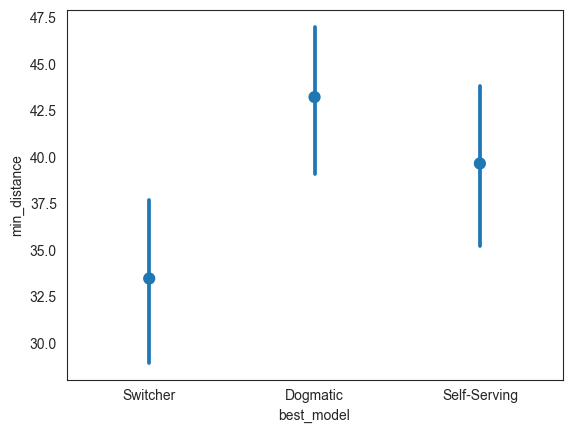

In [767]:
# plot the average minimal distance for each of the models
sns.pointplot(data=subject_models, x='best_model', y='min_distance', join =False)
plt.xticks([0, 1, 2], ['Switcher', 'Dogmatic', 'Self-Serving'])
plt.savefig('../figures/model_min_distance.png')

In [768]:
# for each code, count the number of times that distance_switcher_abs takes the value cero and 
# include it in a column called switcher_correct
updates['switcher_correct'] = np.where(updates['distance_switcher_abs']==0, 1, 0)

# Is treatment different from control?
Do they abandon misspecified beliefs faster in the steroetype treatment?
Are misspecifications more or less common

Is the classification different in the two treatments?

Is alpha different in treatment than in control?

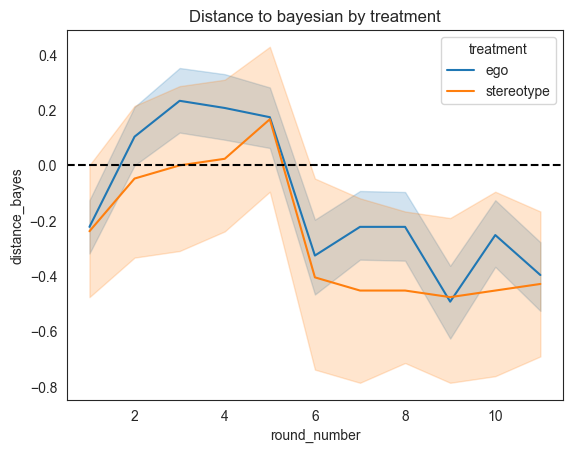

In [769]:
# plot the distance over rounds for each of the treatments
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_bayes', hue='treatment')
#sns.lineplot(data=sim, x='round_number', y='switcher_bayesian', label='switcher', color='blue')
#sns.lineplot(data=sim, x='round_number', y='dogmatic_bayesian', label='dogmatic', color='red')
#sns.lineplot(data=sim, x='round_number', y='self-serving_bayesian', label='self-serving', color='green')
# add a horizontal line at 0 to indicate the bayesian choice
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Distance to bayesian by treatment') 

plt.savefig('../figures/distance_bayes_treatment.png')

<function matplotlib.pyplot.legend(*args, **kwargs)>

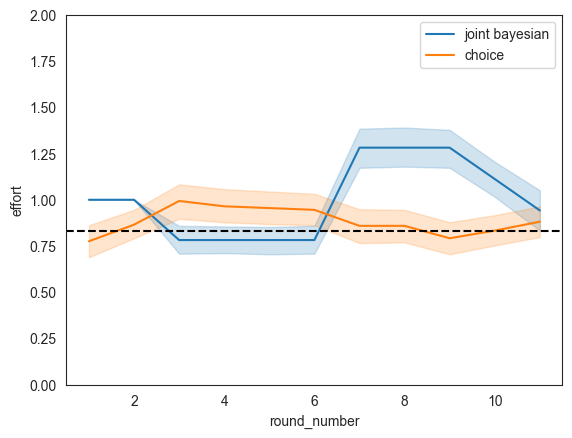

In [771]:
sns.lineplot(data=updates, x='round_number', y='joint-bayesian', label='joint bayesian')
sns.lineplot(data=updates, x='round_number', y='effort', label='choice')
# add a line with the average omega
plt.axhline(y=np.mean(updates['omega']), color='black', linestyle='--')
plt.ylim(0, 2)
plt.ylabel('effort')
plt.legend

<function matplotlib.pyplot.legend(*args, **kwargs)>

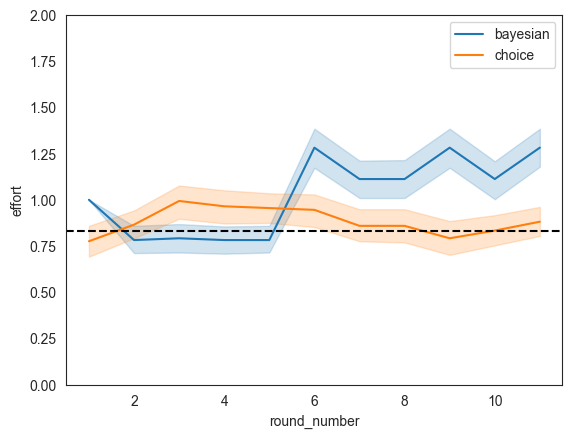

In [772]:
sns.lineplot(data=updates, x='round_number', y='bayesian', label='bayesian')
sns.lineplot(data=updates, x='round_number', y='effort', label='choice')
# add a line with the average omega
plt.axhline(y=np.mean(updates['omega']), color='black', linestyle='--')
plt.ylim(0, 2)
plt.ylabel('effort')
plt.legend

(0.0, 2.0)

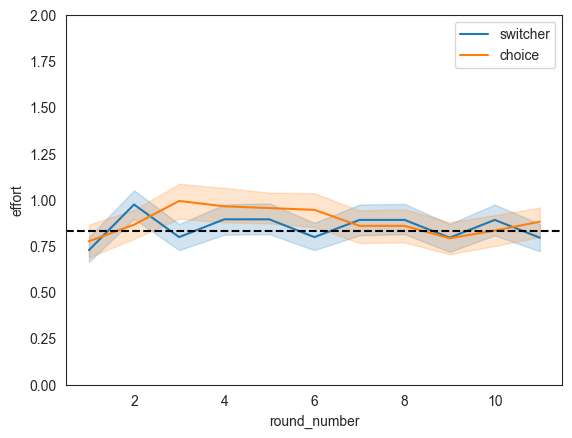

In [773]:
sns.lineplot(data=updates, x='round_number', y='switcher', label='switcher')
sns.lineplot(data=updates, x='round_number', y='effort', label='choice')
# add a line with the average omega
plt.axhline(y=np.mean(updates['omega']), color='black', linestyle='--')
plt.ylabel('effort')
plt.legend()
plt.ylim(0, 2)

(0.0, 2.0)

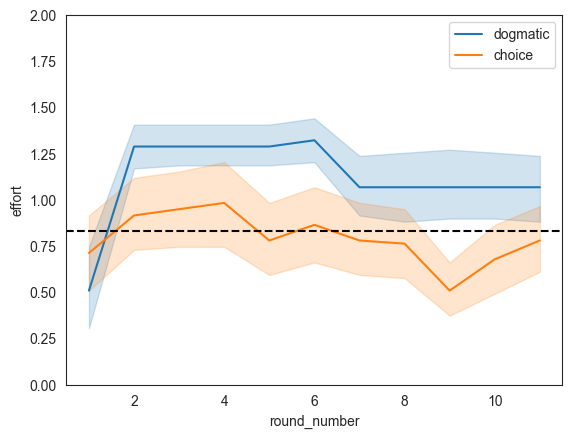

In [774]:
sns.lineplot(data=dogmatic_updates, x='round_number', y='dogmatic', label='dogmatic')
sns.lineplot(data=dogmatic_updates, x='round_number', y='effort', label='choice')
# add a line with the average omega
plt.axhline(y=np.mean(updates['omega']), color='black', linestyle='--')
plt.ylabel('effort')
plt.legend()
plt.ylim(0, 2)

(0.0, 2.0)

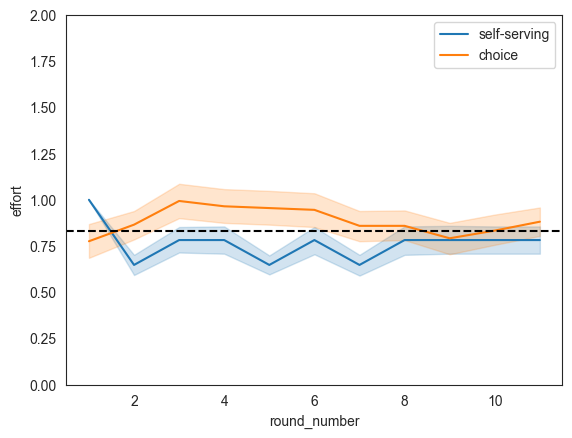

In [775]:
sns.lineplot(data=updates, x='round_number', y='self-serving', label='self-serving')
sns.lineplot(data=updates, x='round_number', y='effort', label='choice')
# add a line with the average omega
plt.axhline(y=np.mean(updates['omega']), color='black', linestyle='--')
plt.ylabel('effort')
plt.legend()
plt.ylim(0, 2)

(-1.0, 1.0)

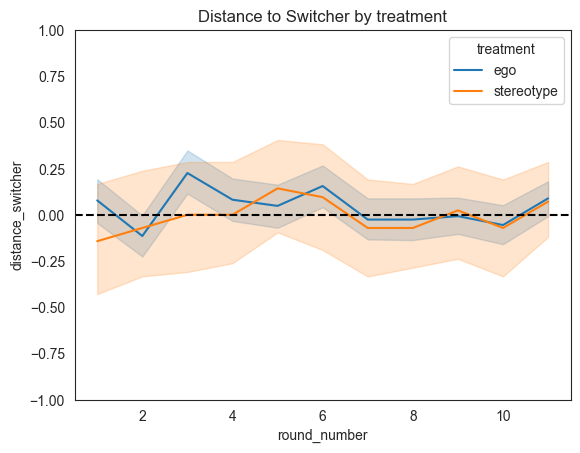

In [776]:
# plot the distance over rounds for each of the treatments and each of the models
# first plot the distance to the switcher
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_switcher', hue='treatment')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Switcher by treatment')
plt.savefig('../figures/distance_switcher_treatment.png')

plt.ylim(-1, 1)

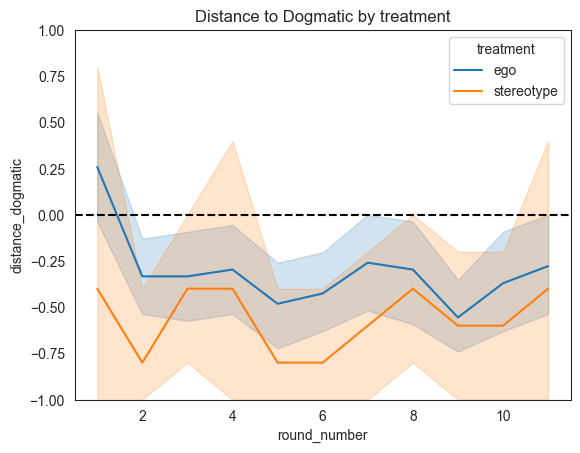

In [777]:
# plot the distance to the dogmatic
sns.set_style("white")
sns.lineplot(data=dogmatic_updates, x='round_number', y='distance_dogmatic', hue='treatment')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Dogmatic by treatment')
plt.ylim(-1, 1)

plt.savefig('../figures/distance_dogmatic_treatment.png')


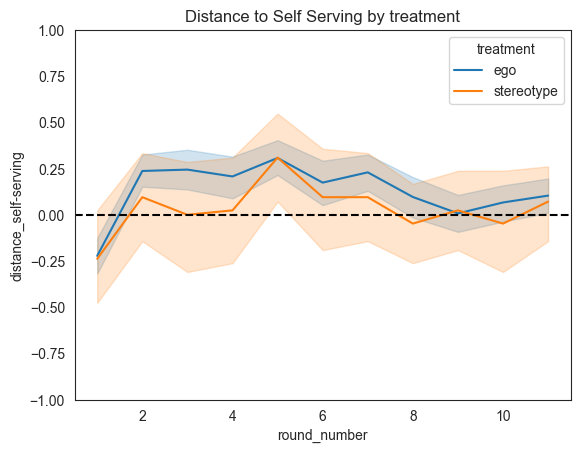

In [778]:

# plot the distance to the self-serving
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_self-serving', hue='treatment')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Self Serving by treatment')
plt.ylim(-1, 1)

plt.savefig('../figures/distance_self-serving_treatment.png')

### T-tests
test if the difference between the observed data and the simulations are different from cero and order them from best fit to worst fit.
plot points with confidence intervals

# What are the characterising features of the subjects that are misspecified?
Do are misspecified subjects more likely to attribute it to others?

## Try to estimate parameters for Self-Attribution bias

In [ ]:
updates['certainty']= updates['certainty']/100

### scores

<Axes: xlabel='score', ylabel='Density'>

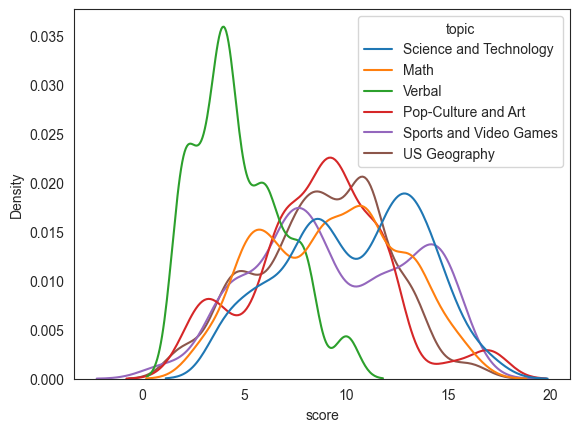

In [779]:
sns.kdeplot(data=updates, x='score', hue='topic')

<Axes: xlabel='belief', ylabel='Density'>

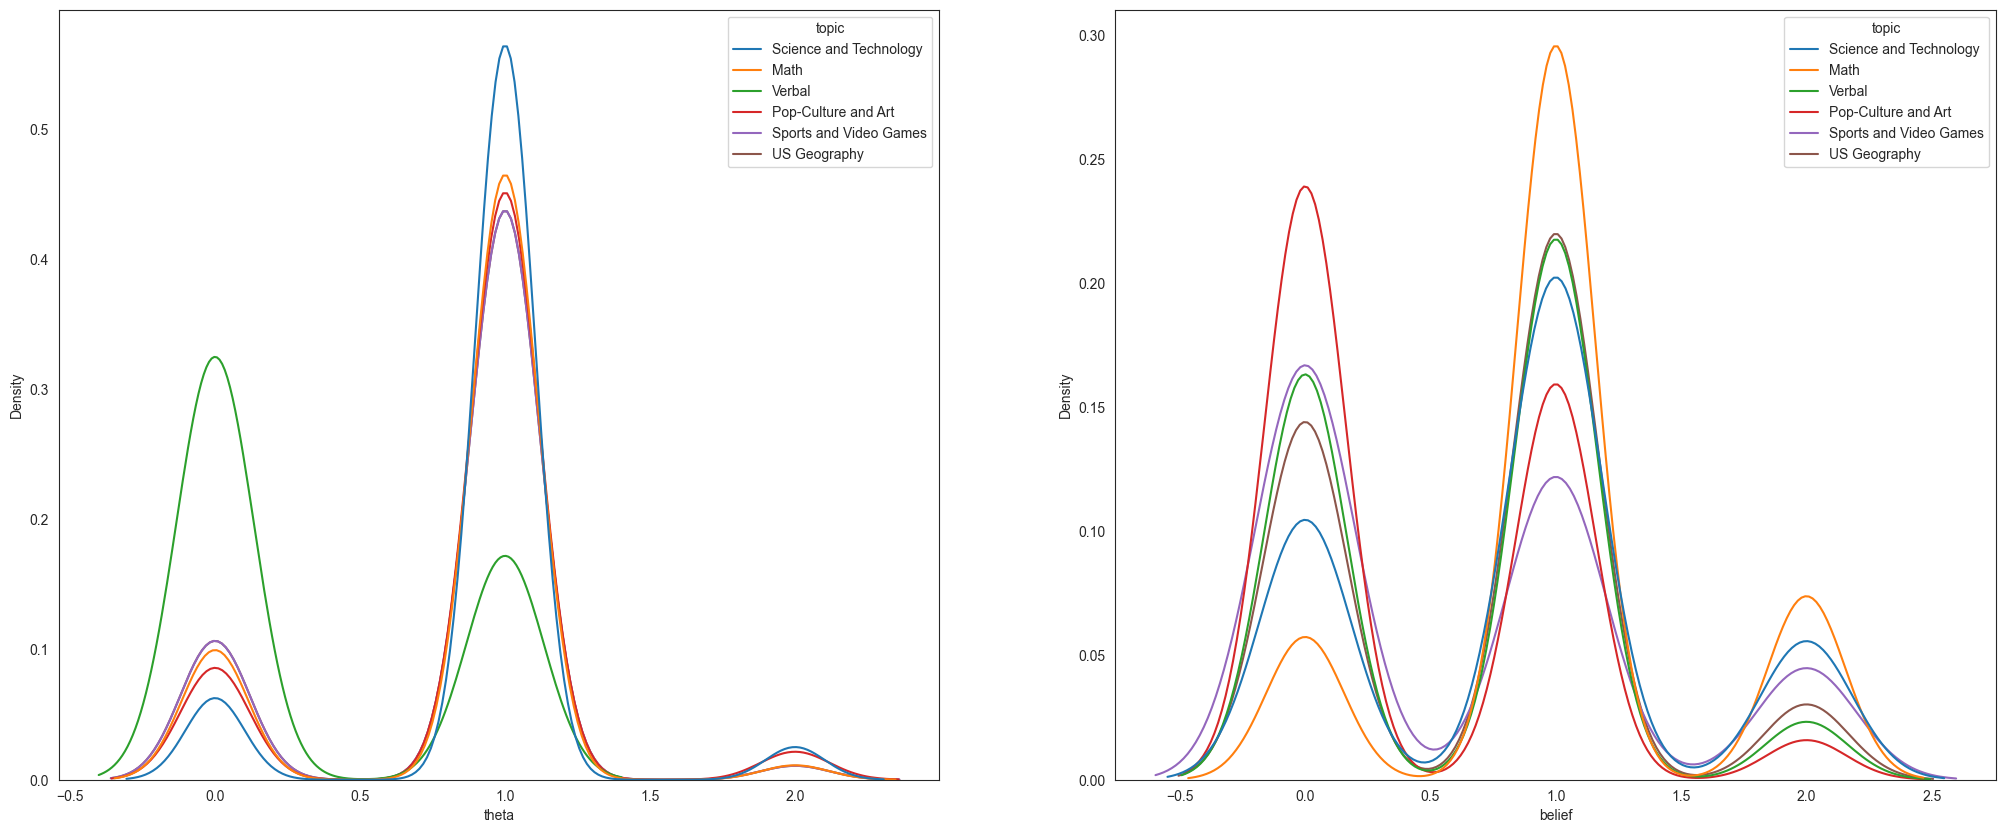

In [780]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10))
sns.kdeplot(data=updates, x='theta', hue='topic', ax=axs[0])
sns.kdeplot(data=updates, x='belief', hue='topic', ax=axs[1])


<Axes: xlabel='misspecification', ylabel='Probability'>

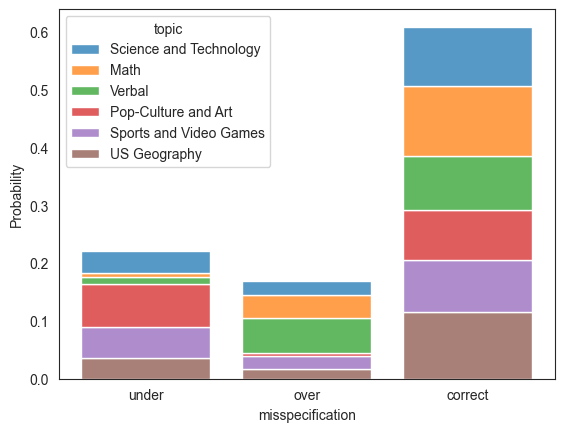

In [781]:
sns.histplot(data=updates, x='misspecification', hue='topic', multiple='stack', stat='probability', shrink=.8, discrete=True)

In [782]:

updates.columns


Index(['index', 'code', 'round_number', 'effort', 'fails', 'last_button',
       'score', 'topic', 'signal', 'belief', 'certainty', 'theta', 'omega',
       'treatment', 'overconfident', 'underconfident', 'correct',
       'misspecification', 'gender', 'nationality', 'misspecification_num',
       'topic_num', 'player_code', 'current_belief_start', 'belief_change',
       'change_indicator', 'change_indicator_sum', 'lr', 'log_lr', 'switcher',
       'dogmatic', 'bayesian', 'self-serving', 'joint-bayesian',
       'switcher_belief', 'distance_joint', 'distance_bayes',
       'distance_switcher', 'distance_dogmatic', 'distance_bayesian',
       'distance_self-serving', 'distance_switcher_abs',
       'distance_dogmatic_abs', 'distance_bayesian_abs',
       'distance_self-serving_abs', 'distance_switcher_sum',
       'distance_dogmatic_sum', 'distance_bayesian_sum',
       'distance_self-serving_sum', 'best_model', 'switcher_correct'],
      dtype='object')

<Axes: xlabel='misspecification', ylabel='certainty'>

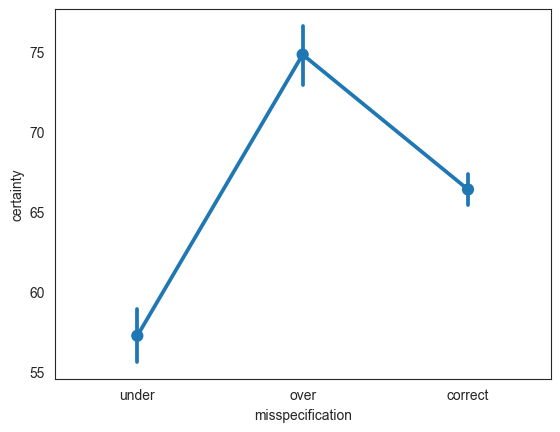

In [783]:
sns.pointplot(data=updates, x='misspecification', y='certainty')

### Changes in misspecifications

/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_30290/1888847311.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_11['first_last'] = round_11['last_button'] - round_11['theta']
/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_30290/1888847311.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_11.loc[round_11['first_last']<0, 'last_specification'] = 'under'


Text(0.5, 1.0, 'belief from guess to last round')

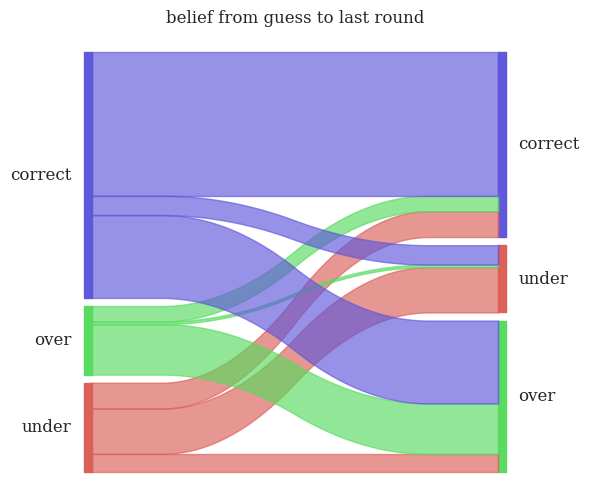

In [784]:
# create a data frame with the last round for each subject
round_11 = updates.loc[updates['round_number']==11]
# check the difference between last_button iminus theta
round_11['first_last'] = round_11['last_button'] - round_11['theta']
# add a column called last_specification that is 'under' if the difference is negative, correct if they are the same and 2 if the difference is positive
round_11.loc[round_11['first_last']<0, 'last_specification'] = 'under'
round_11.loc[round_11['first_last']==0, 'last_specification'] = 'correct'
round_11.loc[round_11['first_last']>0, 'last_specification'] = 'over'

#make a sankey diagram from the inital misspecification to the final one
from pySankey.sankey import sankey
sankey(round_11["misspecification"], round_11["last_specification"], fontsize=12)

plt.title('belief from guess to last round')

/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_30290/3704985241.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_1['first_last'] = round_1['last_button'] - round_1['theta']
/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_30290/3704985241.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_1.loc[round_1['first_last']<0, 'specification'] = 'under'


Text(0.5, 1.0, 'belief round 1 to last round')

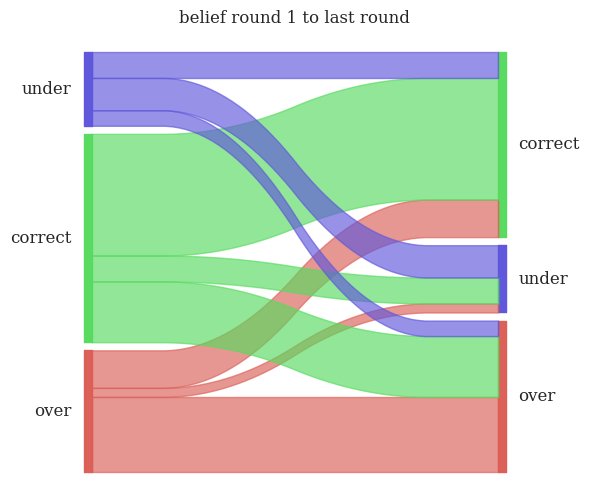

In [785]:
# create a data frame with the last round for each subject
round_1 = updates.loc[updates['round_number']==1]
# check the difference between last_button iminus theta
round_1['first_last'] = round_1['last_button'] - round_1['theta']
# add a column called last_specification that is 'under' if the difference is negative, correct if they are the same and 2 if the difference is positive
round_1.loc[round_1['first_last']<0, 'specification'] = 'under'
round_1.loc[round_1['first_last']==0, 'specification'] = 'correct'
round_1.loc[round_1['first_last']>0, 'specification'] = 'over'

#make a sankey diagram from the inital misspecification to the final one
sankey(round_1['specification'], round_11["last_specification"], fontsize=12)

plt.title('belief round 1 to last round')

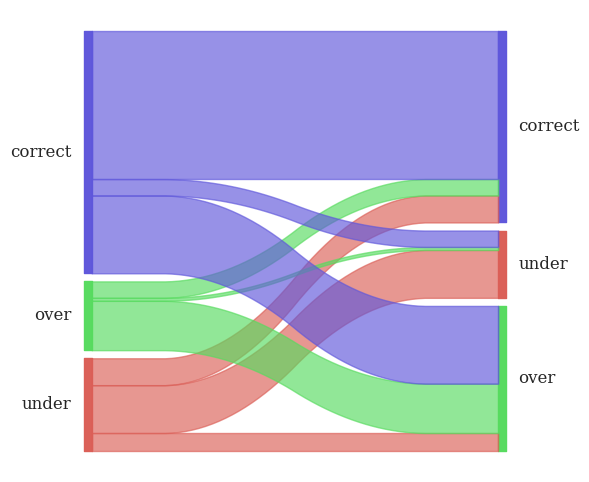

In [786]:
sankey(round_11.loc[round_11['treatment']=='ego', 'misspecification'], round_11["last_specification"], fontsize=12)

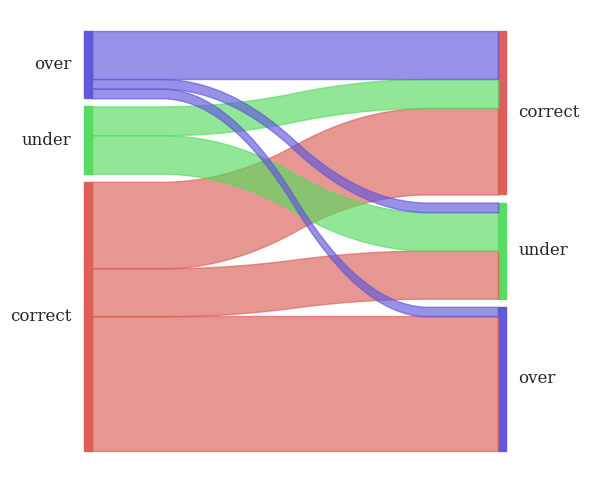

In [787]:
sankey(round_11.loc[round_11['treatment']=='stereotype', 'misspecification'], round_11["last_specification"], fontsize=12)

In [ ]:
# compute the number of subjects that started in each specification and ended in each of them
round_11.groupby(['misspecification', 'last_specification']).count()['code']

misspecification  last_specification
correct           correct               111
                  over                   64
                  under                  15
over              correct                12
                  over                   39
                  under                   2
under             correct                20
                  over                   14
                  under                  35
Name: code, dtype: int64

/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_30290/699583036.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_5['first_last'] = round_5['last_button'] - round_5['theta']
/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_30290/699583036.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_5.loc[round_5['first_last']<0, 'fifth_specification'] = 'under'


Text(0.5, 1.0, 'beliefs from guess to round 5')

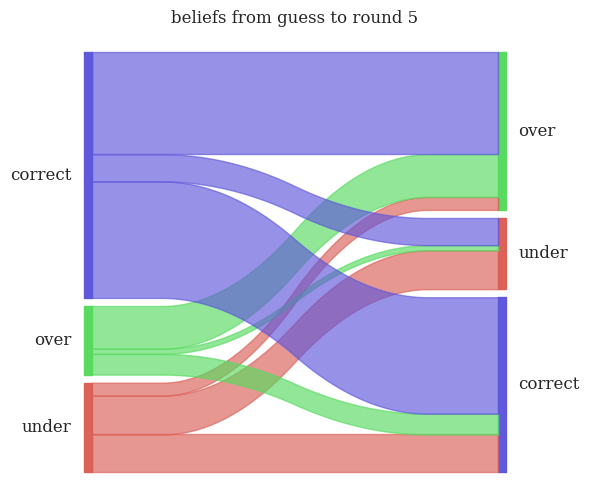

In [ ]:
# create a data frame with the fifth round for each subject
round_5 = updates.loc[updates['round_number']==5]
# check the difference between last_button iminus theta
round_5['first_last'] = round_5['last_button'] - round_5['theta']
# add a column called last_specification that is 'under' if the difference is negative, correct if they are the same and 2 if the difference is positive
round_5.loc[round_5['first_last']<0, 'fifth_specification'] = 'under'
round_5.loc[round_5['first_last']==0, 'fifth_specification'] = 'correct'
round_5.loc[round_5['first_last']>0, 'fifth_specification'] = 'over'


#make a sankey diagram from the inital misspecification to the final one
from pySankey.sankey import sankey
sankey(round_5["misspecification"], round_5["fifth_specification"], fontsize=12)

plt.title('beliefs from guess to round 5')

Text(0.5, 1.0, 'last button first to last round')

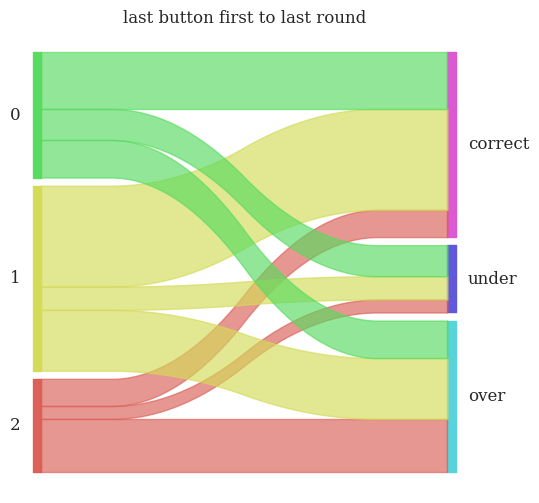

In [ ]:
sankey(updates.loc[updates['round_number']==1, "last_button"], round_11['last_specification'], fontsize=12)

plt.title('last button first to last round')

<Axes: xlabel='last_specification', ylabel='Probability'>

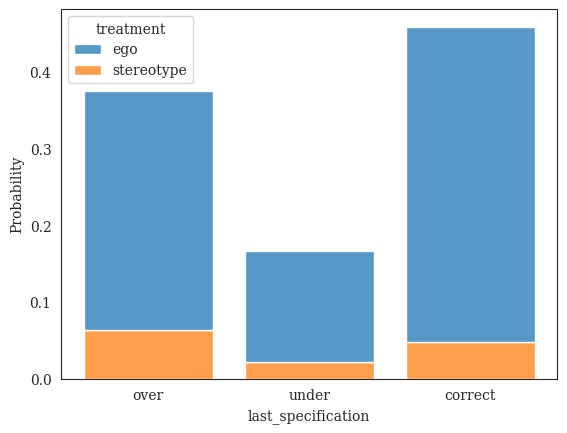

In [788]:
sns.histplot(data=round_11, x='last_specification', hue='treatment', discrete=True, stat='probability', shrink=.8, multiple='stack')

## Consistency in matrix choices

/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_30290/2410606202.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_1['consistent_first']=round_1['belief']==round_1['last_button']
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


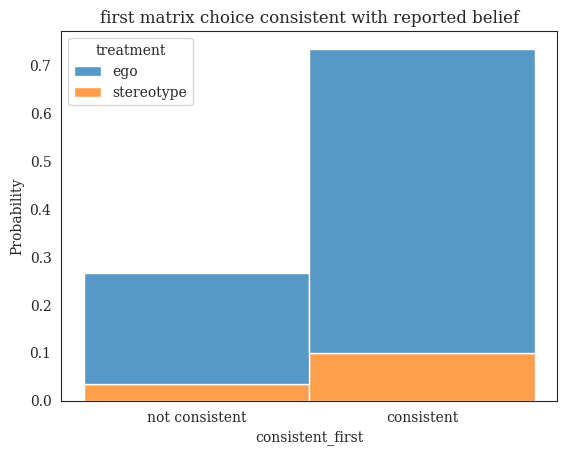

In [789]:
# check if the fist matrix that they choose to see matches the belief they reported
# create a data frame with only round 1
round_1 = updates.loc[updates['round_number']==1, :]

# create a column that indicates whether the last_button in round 1 matches the reported belief
round_1['consistent_first']=round_1['belief']==round_1['last_button']

np.mean(round_1['consistent_first'])

sns.histplot(data=round_1, x='consistent_first', hue='treatment', multiple='stack', 
             discrete=True, stat='probability')
plt.title('first matrix choice consistent with reported belief')
plt.xticks([0, 1], ['not consistent', 'consistent'])

plt.savefig('../figures/consistency_first.png')

### The Subjects who never changed the matrix choice

Text(0.5, 1.0, 'Best fitting models')

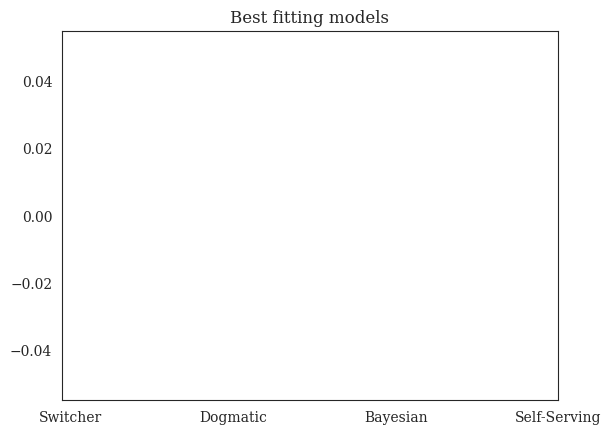

In [790]:
#count the number of subjects for which each of the models id the best fitting among all 4 of them
sns.histplot(data=subject_models[subject_models['change_indicator_sum']==0], x='best_model', discrete=True)
plt.xticks([0, 1, 2, 3], ['Switcher', 'Dogmatic', 'Bayesian', 'Self-Serving'])
plt.title('Best fitting models')


In [791]:
subject_models[subject_models['change_indicator_sum']==0]

,code,treatment,index,round_number,effort,fails,last_button,score,signal,belief,...,distance_switcher_abs,distance_dogmatic_abs,distance_bayesian_abs,distance_self-serving_abs,distance_switcher_sum,distance_dogmatic_sum,distance_bayesian_sum,distance_self-serving_sum,best_model,min_distance


## Choices relative to the optimal

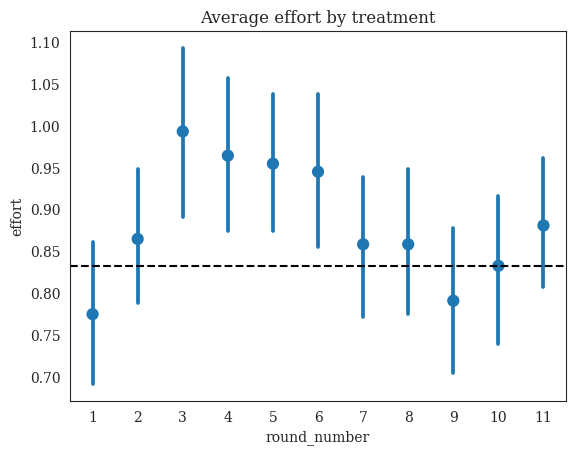

In [792]:
# do a point plot with the average effort by treatment. 
sns.pointplot(data=updates, x='round_number', y='effort', join =False)
plt.title('Average effort by treatment')
# plot a line with the average omega
plt.axhline(y=np.mean(updates['omega']), color='black', linestyle='--')
plt.savefig('../figures/effort_by_treatment.png')

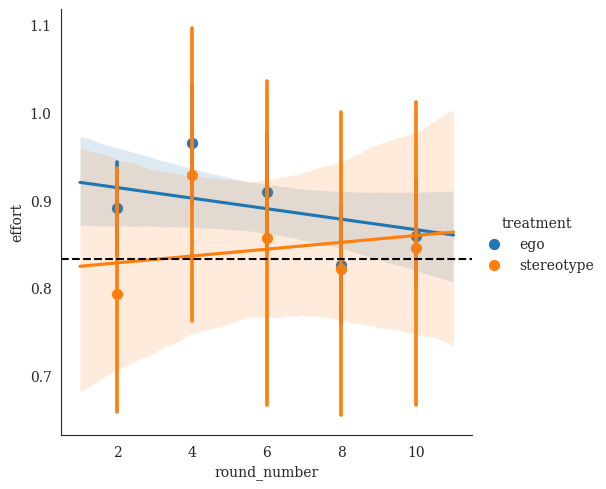

In [793]:
sns.lmplot(data=updates, x='round_number', y='effort', x_bins=5, hue='treatment')
plt.axhline(y=np.mean(updates['omega']), color='black', linestyle='--')

In [794]:
np.array([updates.loc[updates['change_indicator_sum']==0, 'distance_dogmatic_sum'].mean(),
 updates.loc[updates['change_indicator_sum']==0, 'distance_switcher_sum'].mean(),
 updates.loc[updates['change_indicator_sum']==0, 'distance_bayesian_sum'].mean(),
 updates.loc[updates['change_indicator_sum']==0, 'distance_self-serving_sum'].mean()])/6

array([6.51736111, 5.94444444, 7.76388889, 5.77430556])

## Dogmatic v Switcher

In [795]:
# for the cases in which we can compare between switcher and dogmatic
# get the absolute value distance to the predicted paths
dogmatic_updates['distance_switcher_abs']=np.abs(dogmatic_updates['distance_switcher'])
dogmatic_updates['distance_dogmatic_abs']=np.abs(dogmatic_updates['distance_dogmatic'])

In [796]:
# take the average distance to the predicted path
dogmatic_updates[['distance_switcher_abs', 'distance_dogmatic_abs']].mean()

distance_switcher_abs    0.579353
distance_dogmatic_abs    0.787365
dtype: float64

In [797]:
# test if the distances are different
stats.ttest_ind(dogmatic_updates['distance_dogmatic_abs'], dogmatic_updates['distance_switcher_abs'])

Ttest_indResult(statistic=5.933751898785964, pvalue=3.7947987308173745e-09)

In [798]:
len(dogmatic_updates['player_code'].unique())

59

## Byesian V Self-Serving